![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/08.1.Automatic_Question_Generation_Financial_Texts.ipynb)

# Answering Questions on Financial Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

> *While our gross profit margin increased to 81.4% in 2020 from 63.1% in 2019, our revenues declined approximately 27% in 2020...
...
We reported an operating loss of approxiamtely \$8,048,581 million in 2020 as compared to an operating loss of \$7,738,193 in 2019
...*




```
- What is the profit increase?
- What was the decline in revenue?
- What was the operation loss in 2020?
- What was the operation loss in 2019?
````

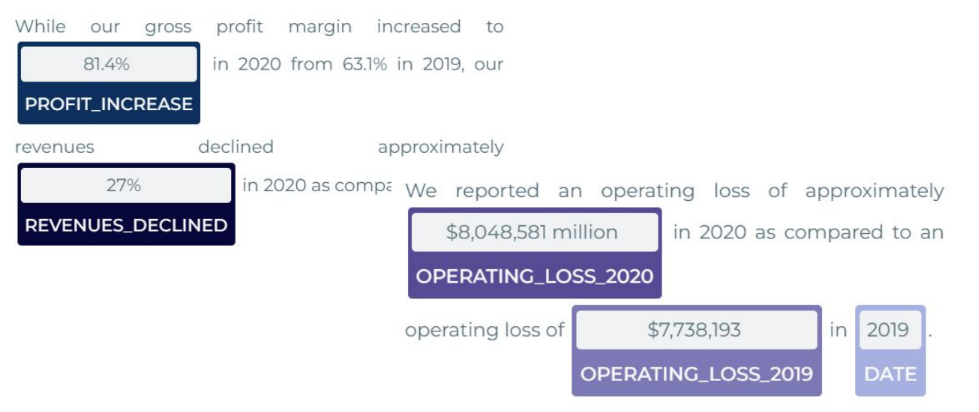



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 


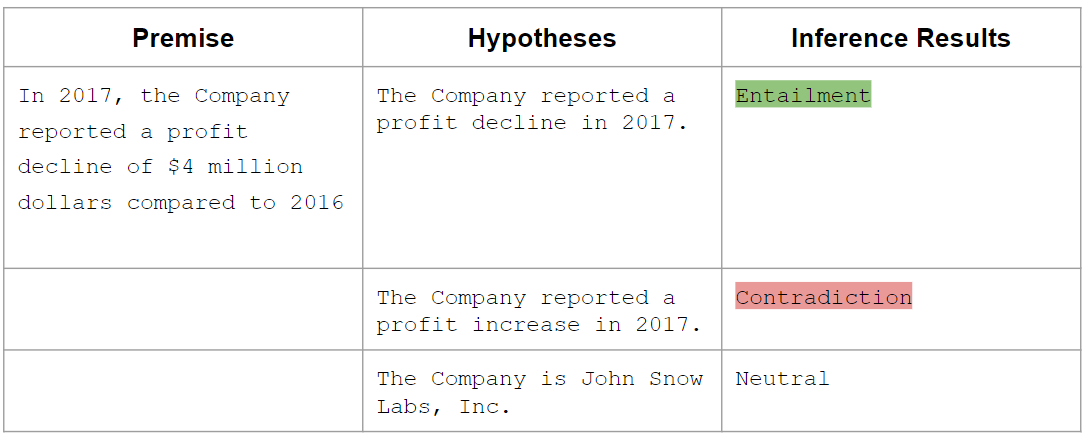

Although we are not getting into the maths of it, it's basically done by using a Language Model to encode P, H and then carry out sentence similarity operations.

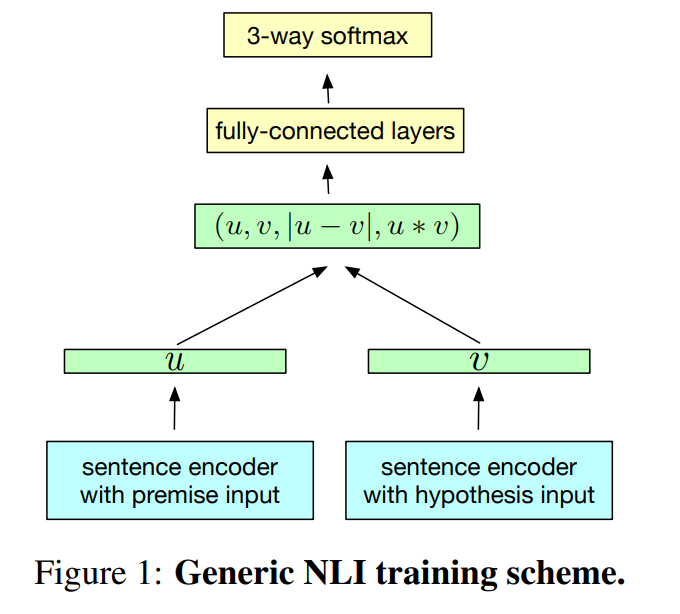

# Creating questions on the fly: NerQuestionGenerator
Financial documents are known to be very long. Although you can divide the documents into paragraphs or sections, and those into sentences, the resulted sentences are still long.

Let's take a look at this example:

> `On June 30, 2021, we terminated our then-existing revolving credit facility, dated January 30, 2017, and entered into a five-year senior unsecured revolving credit facility with a group of lenders led by Bank of America, N.A., as administrative agent (the “2021 Credit Facility”)`

Let's target the extraction of `our then-existing revolving credit facility...`

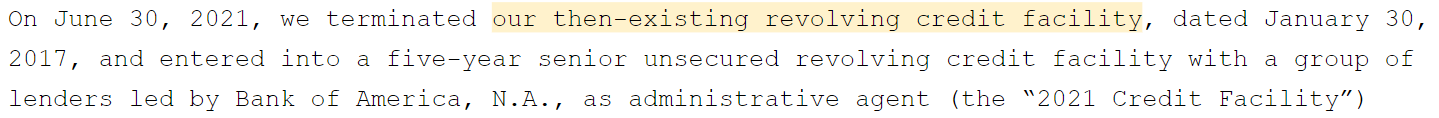

To do that, we can divide these kind of sentences into 3 parts:
1. The Subject (`we`)
2. The Action (`terminated`)
3. The Object (what did we terminate? - `our then-existing revolving credit facility`)

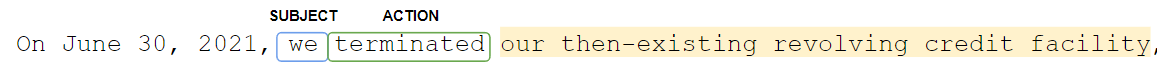

These are the steps we are going to follow:

1. We extract the `Subject` and the `Action`. 
   - Example: `we - SUBJECT`, `terminated - ACTION`

2. We automatically generate a question to ask for the `Object`, using `Subject` and `Action`;
   - Example: `What did we terminate (what we terminated)?`

3. Use the question and the sentence to retrieve `Object`
   - Example: `What we terminated? our then-existing revolving credit facility`

Last, but not least, it's very important to chose a domain-specific Question Answering model.


# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [2]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

Let's read and normalize a little the spacing of the NLP models may think those are different sentences and get unexpected results.

In [6]:
text = """On June 30, 2021, we terminated our then-existing revolving credit facility, dated January 30, 2017, and entered into a five-year senior unsecured revolving credit facility with a group of lenders led by Bank of America, N.A., as administrative agent (the “2021 Credit Facility”)"""

# Use Dependency Parsing to retrieve SUBJECT and ACTION
Let's go the *grammatical* way!

Let's use `Part of Speech` and  `Dependency Parsing` to check for the SUBJECT and ACTION.

- `PoS` retrieves morphological information of the words, like `VERB`, `NOUN`, etc.
- `Dependency Parsing` categories chunks by their grammatical role: `SUBJECT` and connects chunks together using their dependencies.

For more information about `PoS` and `DepParsing`, please check the Spark NLP (Open Source) notebooks.

In [7]:
import pandas as pd

documentAssembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
  .setInputCols("document")\
  .setOutputCol("token")

pos = nlp.PerceptronModel.pretrained("pos_anc", 'en')\
  .setInputCols("document", "token")\
  .setOutputCol("pos")

dep_parser = nlp.DependencyParserModel.pretrained('dependency_conllu')\
  .setInputCols(["document", "pos", "token"])\
  .setOutputCol("dependency")

nlpPipeline = nlp.Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        pos,
        dep_parser
        ])

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [8]:
text_df = spark.createDataFrame([[text]]).toDF("text")

fit_model = nlpPipeline.fit(text_df)

result = fit_model.transform(text_df)

result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               token|                 pos|          dependency|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|On June 30, 2021,...|[{document, 0, 27...|[{token, 0, 1, On...|[{pos, 0, 1, IN, ...|[{dependency, 0, ...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [9]:
from pyspark.sql import functions as F
result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.token.begin, 
                                                 result.token.end, 
                                                 result.dependency.result,
                                                 result.pos.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end"),
                          F.expr("cols['3']").alias("dependency"),
                          F.expr("cols['4']").alias("PoS")).toPandas()

In [10]:
result_df

,chunk,begin,end,dependency,PoS
0,On,0,1,June,IN
1,June,3,6,terminated,NNP
2,30,8,9,June,CD
3,",",10,10,June,","
4,2021,12,15,June,CD
5,",",16,16,terminated,","
6,we,18,19,terminated,PRP
7,terminated,21,30,ROOT,VBD
8,our,32,34,revolving,PRP$
9,then-existing,36,48,revolving,JJ


### Let's visualize with Spark NLP Display
To do that, we need the results of a LightPipeline

In [11]:
lp = nlp.LightPipeline(fit_model)
pipeline_result = lp.fullAnnotate(text)

In [12]:
from sparknlp_display import DependencyParserVisualizer

dependency_vis = DependencyParserVisualizer()

dependency_vis.display(pipeline_result[0], #should be the results of a single example, not the complete dataframe.
                       pos_col = 'pos', #specify the pos column
                       dependency_col = 'dependency' #specify the dependency column
                       )

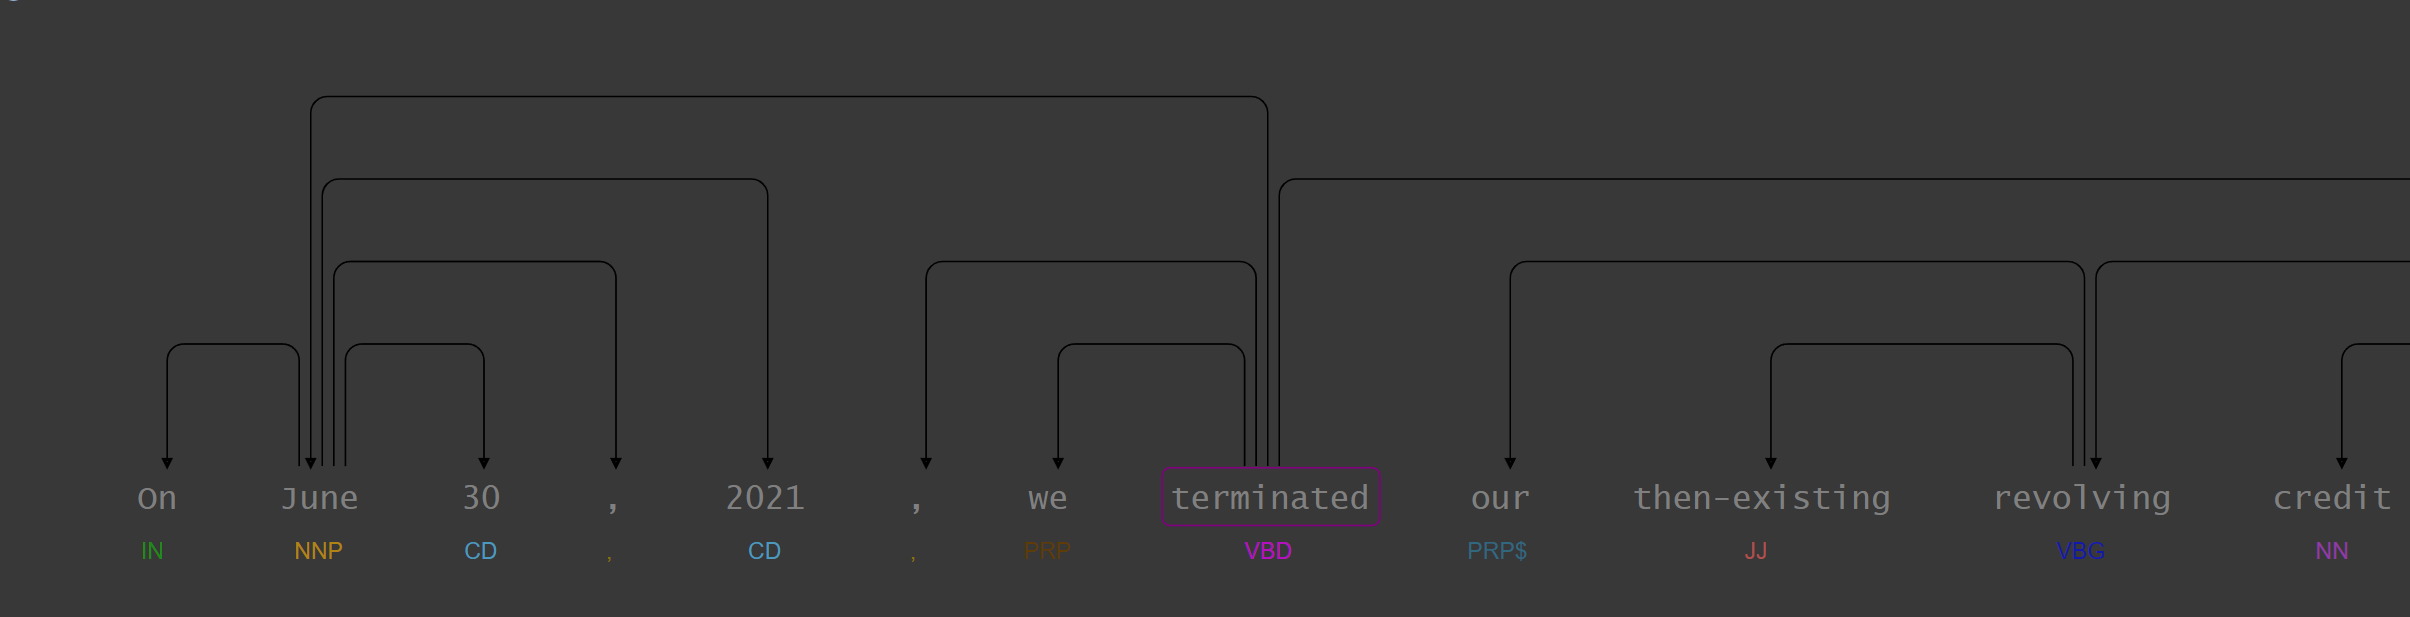

## Finding the `ACTION`
Let's get the root of the dependency trees (or the verb from pos)

In [13]:
actions = result_df[(result_df['dependency']=='ROOT') | (result_df['PoS']=='VB')]
actions

,chunk,begin,end,dependency,PoS
7,terminated,21,30,ROOT,VBD
14,dated,77,81,ROOT,VBN


In [14]:
action = actions['chunk'].tolist()[0]
action

'terminated'

Is there any verb modifier depending on `terminated`?

In [15]:
action_modifier = result_df[(result_df['dependency']=='terminated') & (result_df['PoS']=='MD')]
action_modifier

,chunk,begin,end,dependency,PoS


## Finding the `SUBJECT`


Let's get the `PRP` tokens (pronouns) or 'NNP' (proper nouns)

In [16]:
nouns = result_df[(result_df['dependency']==action) & (result_df['PoS']=='PRP')]
nouns

,chunk,begin,end,dependency,PoS
6,we,18,19,terminated,PRP


We could here obtain also the modifiers, as the articles / determinants, but it's in most cases irrelevant in terms of meaning.

In [17]:
noun = nouns['chunk'].tolist()[0]

In [18]:
noun

'we'

## Question:

In [19]:
PARTICLE = "What" # We want the object, so this is the right W-word
SUBJECT = noun
ACTION = action

QUESTION = " ".join([PARTICLE, SUBJECT, ACTION, "?"])
QUESTION

'What we terminated ?'

### Correct English

Although Language Models don't really care, we can try to create a question in a more correct English.

`VBN` and `VBD` are past of the verbs.

In [20]:
actions = result_df[(result_df['dependency']=='ROOT') | (result_df['PoS']=='VB')]
actions

,chunk,begin,end,dependency,PoS
7,terminated,21,30,ROOT,VBD
14,dated,77,81,ROOT,VBN


In [21]:
lemmatizer = nlp.LemmatizerModel.pretrained() \
  .setInputCols(["token"]) \
  .setOutputCol("lemma")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [22]:
pipeline = nlp.Pipeline() \
  .setStages([
    documentAssembler,
    tokenizer,
    lemmatizer
  ])

data = spark.createDataFrame(actions[['chunk']]).toDF("text")

result = pipeline.fit(data).transform(data)
result.selectExpr("lemma.result").show(truncate=False)

+-----------+
|result     |
+-----------+
|[terminate]|
|[date]     |
+-----------+



In [23]:
lemmatized_action = result.select('lemma.result').collect()[0].result[0]
lemmatized_action

'terminate'

In [24]:
PARTICLE = "What" # We want the object, so this is the right W-word
SUBJECT = noun
ACTION = action

QUESTION = " ".join([PARTICLE, 'did', SUBJECT, lemmatized_action, "?"])
QUESTION

'What did we terminate ?'

# User NER or ContextualParser
If you use NER or ContextualParser (or other annotators extracting ner chunks) to extract `SUBJECT` and `ENTITY`, you can use `NerQuestionGenerator` to **automatically generate those questions**.

If you are curious about seeing this in a real use case, check [Legal NLP Workshop](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/tutorials/Certification_Trainings_JSL/Legal)

Here is a small spoiler:

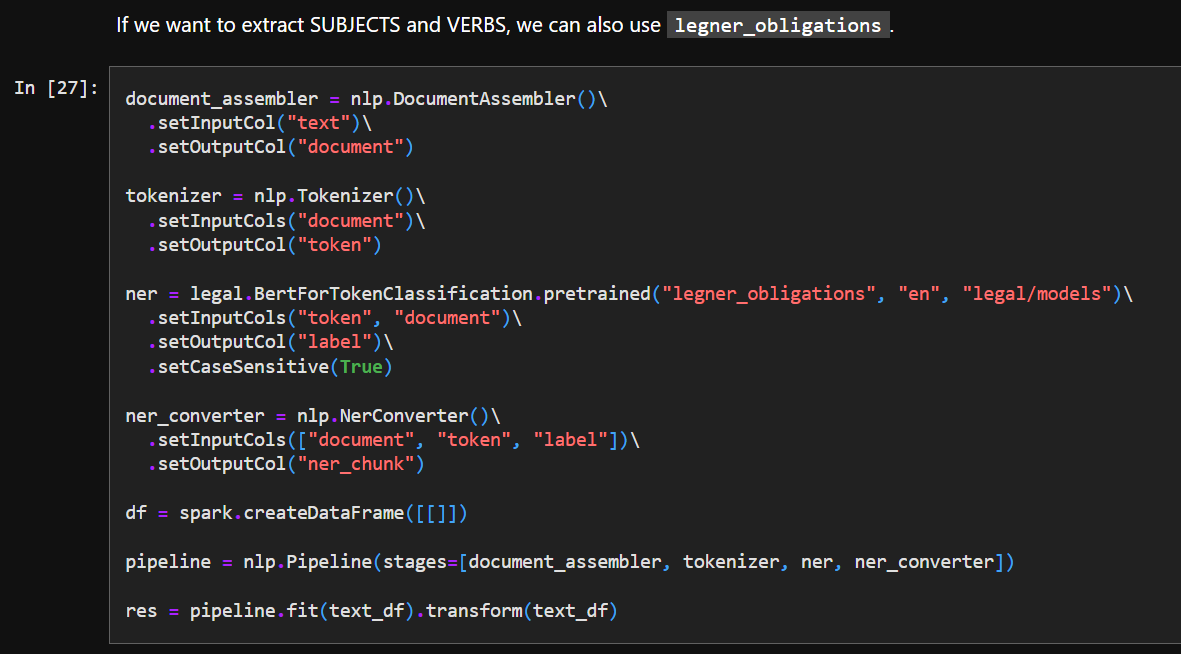

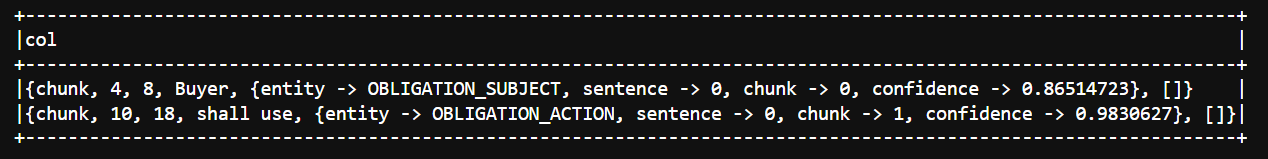

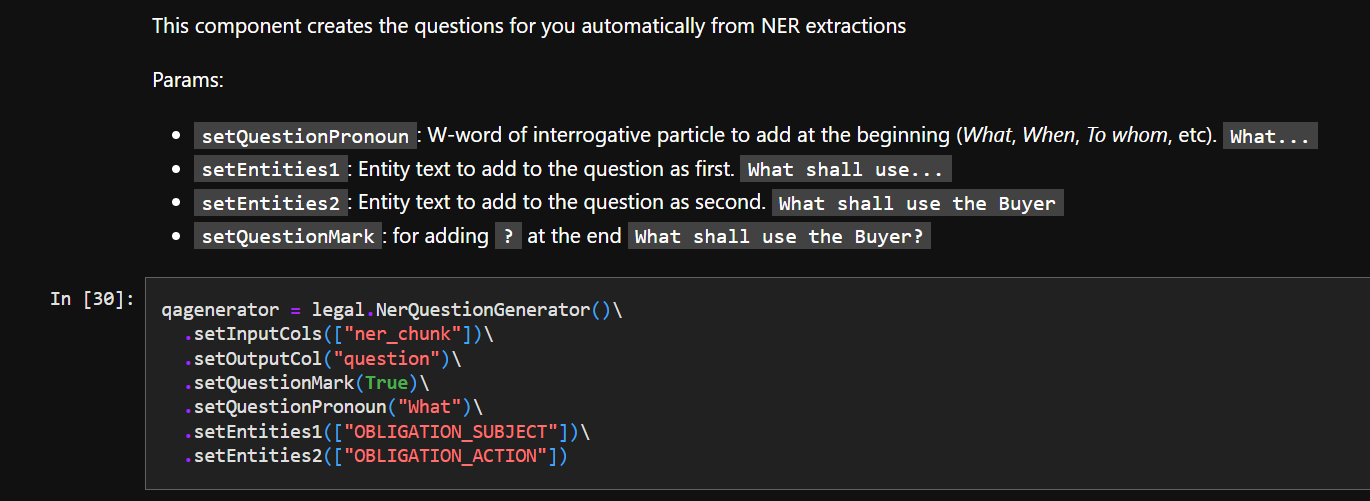

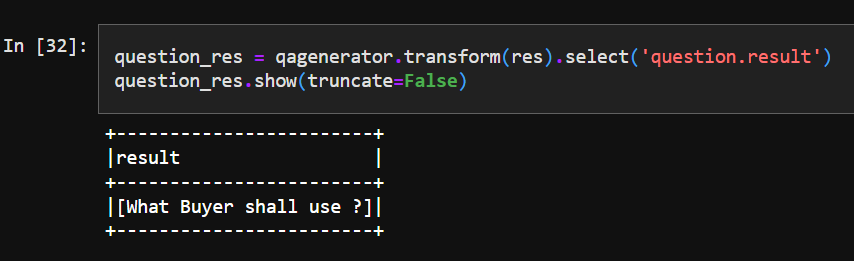